<a href="https://colab.research.google.com/github/Buraporn-Subsomboon/Buraporn_DTSC3020_Fall2025/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

file_path = 'Hotel_Reviews.csv'

# 1. Load the DataFrame
try:
    df = pd.read_csv(file_path)
    print("✅ DataFrame 'df' loaded successfully using full path.")
    print(f"Total rows loaded: {len(df)}")
except FileNotFoundError:
    print("❌ ERROR: Double-check that you extracted the .csv file and the path is correct.")
    raise

# 2. Rerun the rest of the Feature Engineering code...
def categorize_score(score):
    if score in [1.0, 10.0]:
        return 'Extreme (1 or 10)'
    elif score in [4.0, 5.0, 6.0, 7.0]:
        return 'Moderate (4-7)'
    else:
        return 'Other'

df['Score_Bin'] = df['Reviewer_Score'].apply(categorize_score)
df_h1 = df[df['Score_Bin'].isin(['Extreme (1 or 10)', 'Moderate (4-7)'])].copy()

print("✅ Hypothesis 1 features created successfully.")

# --- Feature Engineering for Hypothesis 3 ---

# Calculate the Net Sentiment (difference between positive and negative word counts)
df['Net_Sentiment'] = df['Review_Total_Positive_Word_Counts'] - df['Review_Total_Negative_Word_Counts']

# Select only the relevant columns for H3 visualization
df_h3 = df[['Net_Sentiment', 'Reviewer_Score', 'Average_Score']].copy()

print("✅ 'Net_Sentiment' and 'df_h3' created.")
# --- Feature Engineering for Hypothesis 2 ---

# Define conceptual keywords for the two main aspects
staff_service_keywords = ['staff', 'service', 'rude', 'attitude', 'check in', 'check out', 'unfriendly', 'slow']
infrastructure_keywords = ['room size', 'bed', 'noise', 'cleanliness', 'wifi', 'air con', 'old', 'small', 'dirty', 'maintenance']

# Function to check for aspect presence in the Negative Review
def find_negative_aspect(review_text):
    if pd.isna(review_text) or review_text == 'No Negative':
        return 'None'

    review_text = review_text.lower()

    found_staff = any(kw in review_text for kw in staff_service_keywords)
    found_infra = any(kw in review_text for kw in infrastructure_keywords)

    # Prioritize 'Mixed' if both are found, or assign the specific one
    if found_staff and found_infra:
        return 'Mixed (Staff & Infra)'
    elif found_staff:
        return 'Staff/Service'
    elif found_infra:
        return 'Infrastructure'
    else:
        # Group other common negatives together for comparison
        return 'Other Negative Aspect'

# Apply the function to the Negative Review column
df['Primary_Negative_Aspect'] = df['Negative_Review'].apply(find_negative_aspect)

# Calculate the key metric: Average Reviewer Score per Aspect
df_h2_metrics = df.groupby('Primary_Negative_Aspect')['Reviewer_Score'].mean().reset_index()
df_h2_metrics.columns = ['Aspect', 'Average_Score']

# Filter to the most relevant categories for the hypothesis comparison
df_h2_final = df_h2_metrics[df_h2_metrics['Aspect'].isin(['Staff/Service', 'Infrastructure', 'Other Negative Aspect'])].copy()

# Calculate the overall mean score for the reference line in the plot
overall_avg_score = df['Reviewer_Score'].mean()

print("✅ 'Primary_Negative_Aspect' and 'df_h2_final' created.")

✅ DataFrame 'df' loaded successfully using full path.
Total rows loaded: 76527
✅ Hypothesis 1 features created successfully.
✅ 'Net_Sentiment' and 'df_h3' created.
✅ 'Primary_Negative_Aspect' and 'df_h2_final' created.


In [2]:
!pip install matplotlib seaborn

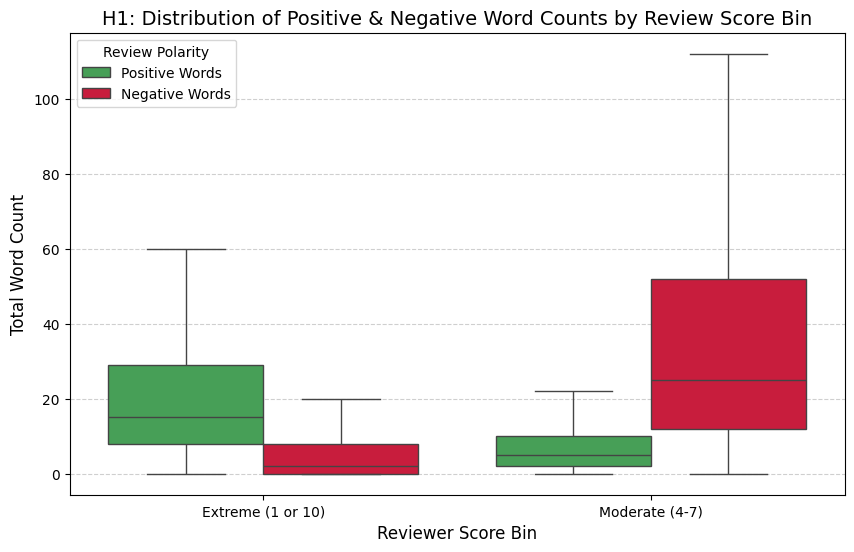

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare data for plotting (long format is best for seaborn)
df_plot1 = pd.melt(df_h1,
                   id_vars=['Score_Bin'],
                   value_vars=['Review_Total_Positive_Word_Counts', 'Review_Total_Negative_Word_Counts'],
                   var_name='Polarity',
                   value_name='Word_Count')

# Map Polarity names for clearer labels
polarity_map = {'Review_Total_Positive_Word_Counts': 'Positive Words',
                'Review_Total_Negative_Word_Counts': 'Negative Words'}
df_plot1['Polarity'] = df_plot1['Polarity'].map(polarity_map)

# 2. Create the grouped Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot1,
            x='Score_Bin',
            y='Word_Count',
            hue='Polarity',
            palette={'Positive Words': '#38AE4D', 'Negative Words': '#E4002B'}, # Green/Red color scheme
            showfliers=False) # Hiding outliers for a cleaner look at distribution

plt.title('H1: Distribution of Positive & Negative Word Counts by Review Score Bin', fontsize=14)
plt.xlabel('Reviewer Score Bin', fontsize=12)
plt.ylabel('Total Word Count', fontsize=12)
plt.legend(title='Review Polarity')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

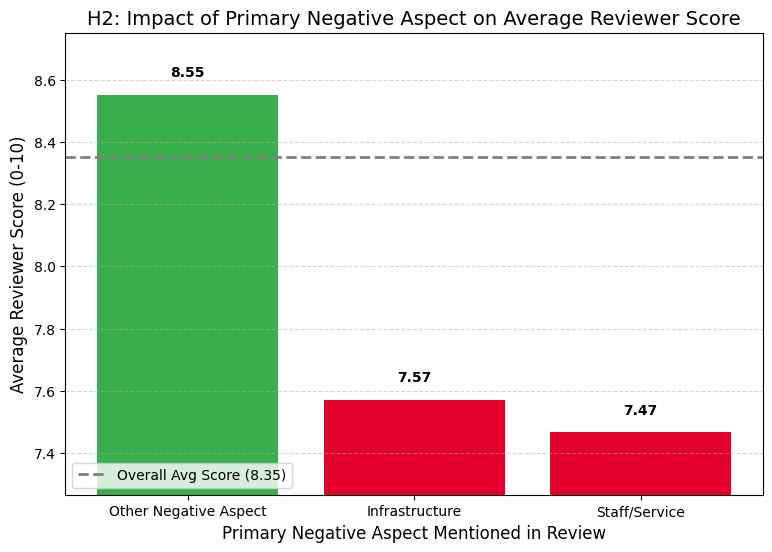

In [4]:
# 1. Sort the data to emphasize the aspect with the lowest score (lowest average score on top)
df_h2_sorted = df_h2_final.sort_values(by='Average_Score', ascending=False)

# Define a color map based on deviation from the overall average
colors = ['#E4002B' if score < overall_avg_score else '#38AE4D' for score in df_h2_sorted['Average_Score']]

# 2. Create the Bar Chart
plt.figure(figsize=(9, 6))
bars = plt.bar(df_h2_sorted['Aspect'], df_h2_sorted['Average_Score'], color=colors)
plt.axhline(overall_avg_score, color='gray', linestyle='--', label=f'Overall Avg Score ({overall_avg_score:.2f})', linewidth=2)

# Add score labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(min(df_h2_final['Average_Score']) - 0.2, max(df_h2_final['Average_Score']) + 0.2)
plt.title('H2: Impact of Primary Negative Aspect on Average Reviewer Score', fontsize=14)
plt.xlabel('Primary Negative Aspect Mentioned in Review', fontsize=12)
plt.ylabel('Average Reviewer Score (0-10)', fontsize=12)
plt.legend(loc='lower left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

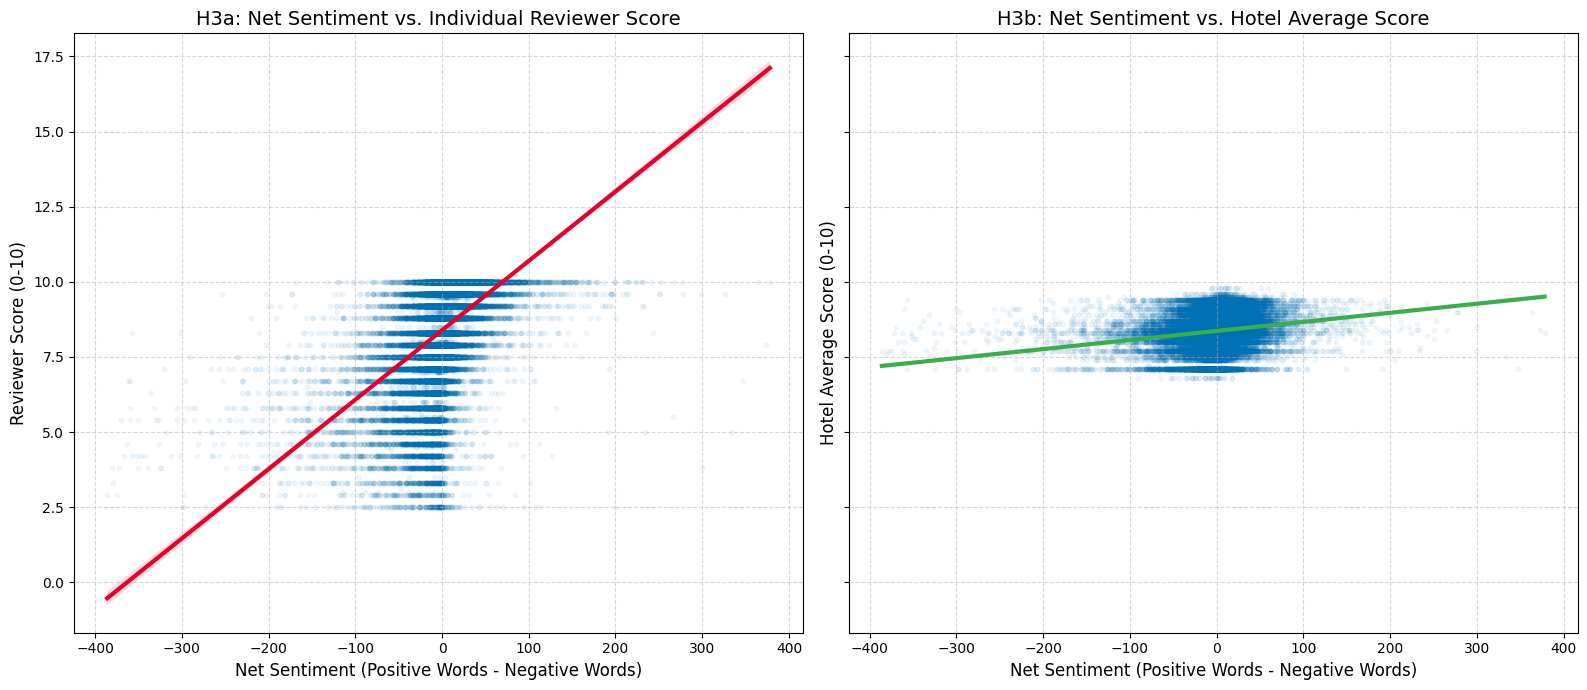

Correlation (r) between Net Sentiment and Individual Reviewer Score: 0.4728280781013598
Correlation (r) between Net Sentiment and Hotel Average Score: 0.17271648899695227


In [8]:
# Use the full dataset (df) for the most accurate correlation assessment
df_sample = df.sample(n=50000, random_state=42) # Sample for faster plotting and cleaner visualization

# 1. Set up the figure for small multiples
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Subplot 1: Net Sentiment vs. Individual Reviewer Score
sns.regplot(x='Net_Sentiment', y='Reviewer_Score', data=df_sample,
            ax=axes[0],
            scatter_kws={'alpha':0.05, 's':10, 'color': '#0070B5'}, # Blue for individual
            line_kws={"color": "#E4002B", 'linewidth': 3}) # Red for regression line
axes[0].set_title('H3a: Net Sentiment vs. Individual Reviewer Score', fontsize=14)
axes[0].set_xlabel('Net Sentiment (Positive Words - Negative Words)', fontsize=12)
axes[0].set_ylabel('Reviewer Score (0-10)', fontsize=12)
axes[0].grid(axis='both', linestyle='--', alpha=0.5)

# Subplot 2: Net Sentiment vs. Hotel Average Score
sns.regplot(x='Net_Sentiment', y='Average_Score', data=df_sample,
            ax=axes[1],
            scatter_kws={'alpha':0.05, 's':10, 'color': '#0070B5'}, # Blue for individual
            line_kws={"color": "#38AE4D", 'linewidth': 3}) # Green for regression line
axes[1].set_title('H3b: Net Sentiment vs. Hotel Average Score', fontsize=14)
axes[1].set_xlabel('Net Sentiment (Positive Words - Negative Words)', fontsize=12)
axes[1].set_ylabel('Hotel Average Score (0-10)', fontsize=12) # Shared Y-axis label
axes[1].grid(axis='both', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()

# You would calculate the correlation coefficients (r) here to formally confirm the visual findings:
corr_reviewer = df['Net_Sentiment'].corr(df['Reviewer_Score'])
corr_average = df['Net_Sentiment'].corr(df['Average_Score'])
print(f"Correlation (r) between Net Sentiment and Individual Reviewer Score: {corr_reviewer}")
print(f"Correlation (r) between Net Sentiment and Hotel Average Score: {corr_average}")